In [62]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np


In [63]:
ttc = pd.read_csv('train_transaction.csv', low_memory=False)
tic = pd.read_csv('train_identity.csv', low_memory=False)
tstc = pd.read_csv('test_transaction.csv', low_memory=False)
tstic = pd.read_csv('test_identity.csv', low_memory=False)

In [64]:
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [65]:
ttc = reduce_mem_usage(ttc)
tic = reduce_mem_usage(tic)
tstc = reduce_mem_usage(tstc)
tstic = reduce_mem_usage(tstic)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [66]:
train = pd.merge(ttc, tic, on = 'TransactionID', how = 'left')
test = pd.merge(tstc, tstic, on = 'TransactionID', how = 'left')

In [67]:
del ttc, tic, tstc, tstic

In [ ]:
miss_data = pd.isnull(train).sum().sort_values(ascending=False)
miss_per = (miss_data/len(train))*100
missing_data = pd.concat(objs = [miss_data, miss_per], keys = ['Columns','Missing values percentage'], axis = 1)

In [ ]:
def delnullcol(dt):
    nullcol = [col for col in dt.columns if dt[col].isnull().sum()/dt.shape[0] >= 0.9]
    return nullcol

In [ ]:
rep_vals = [col for col in train.columns if train[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
cols=[]
for col in rep_vals:
    cols.append(train[col].value_counts(dropna = False).values[0])

In [ ]:
def repcols(dt):
    rep_vals = [col for col in dt.columns if dt[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
    return rep_vals

In [ ]:
def useless_cols(dt, exep):
    null_cols = delnullcol(dt)
    print("More than 90% null: " + str(len(null_cols)))
    too_many_repeated = repcols(dt)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(null_cols + too_many_repeated))
    cols_to_drop.remove(exep)
    return cols_to_drop

In [ ]:
cols_to_drop = useless_cols(train, 'isFraud')

In [ ]:
def find_Major_values(dt, threshold):
    Major_values = []
    t=dt.value_counts(dropna = True, normalize = True)
    for i in range(len(t)):
        if t.values[i] >= threshold:
            Major_values.append(t.values[i])
    return Major_values

In [ ]:
def find_Major_Devices(Major_values,dt):
    Major_Devices = []
    t = dt.value_counts(dropna = True, normalize = True)
    for i in Major_values:
        for j in t.items():
            if j[1] == i:
                Major_Devices.append(j[0])
    return Major_Devices

In [ ]:
def find_plot(Major_Devices,d,dt):
    plothis=[]
    for i in range(len(Major_Devices)):
        plothis.append(d.loc[dt == Major_Devices[i]])
    if len(plothis) == 0:
        return 10
    else:
        plothis = pd.concat(objs = [i for i in plothis], axis = 0)
        return plothis

In [ ]:
sns.set(style = "whitegrid")

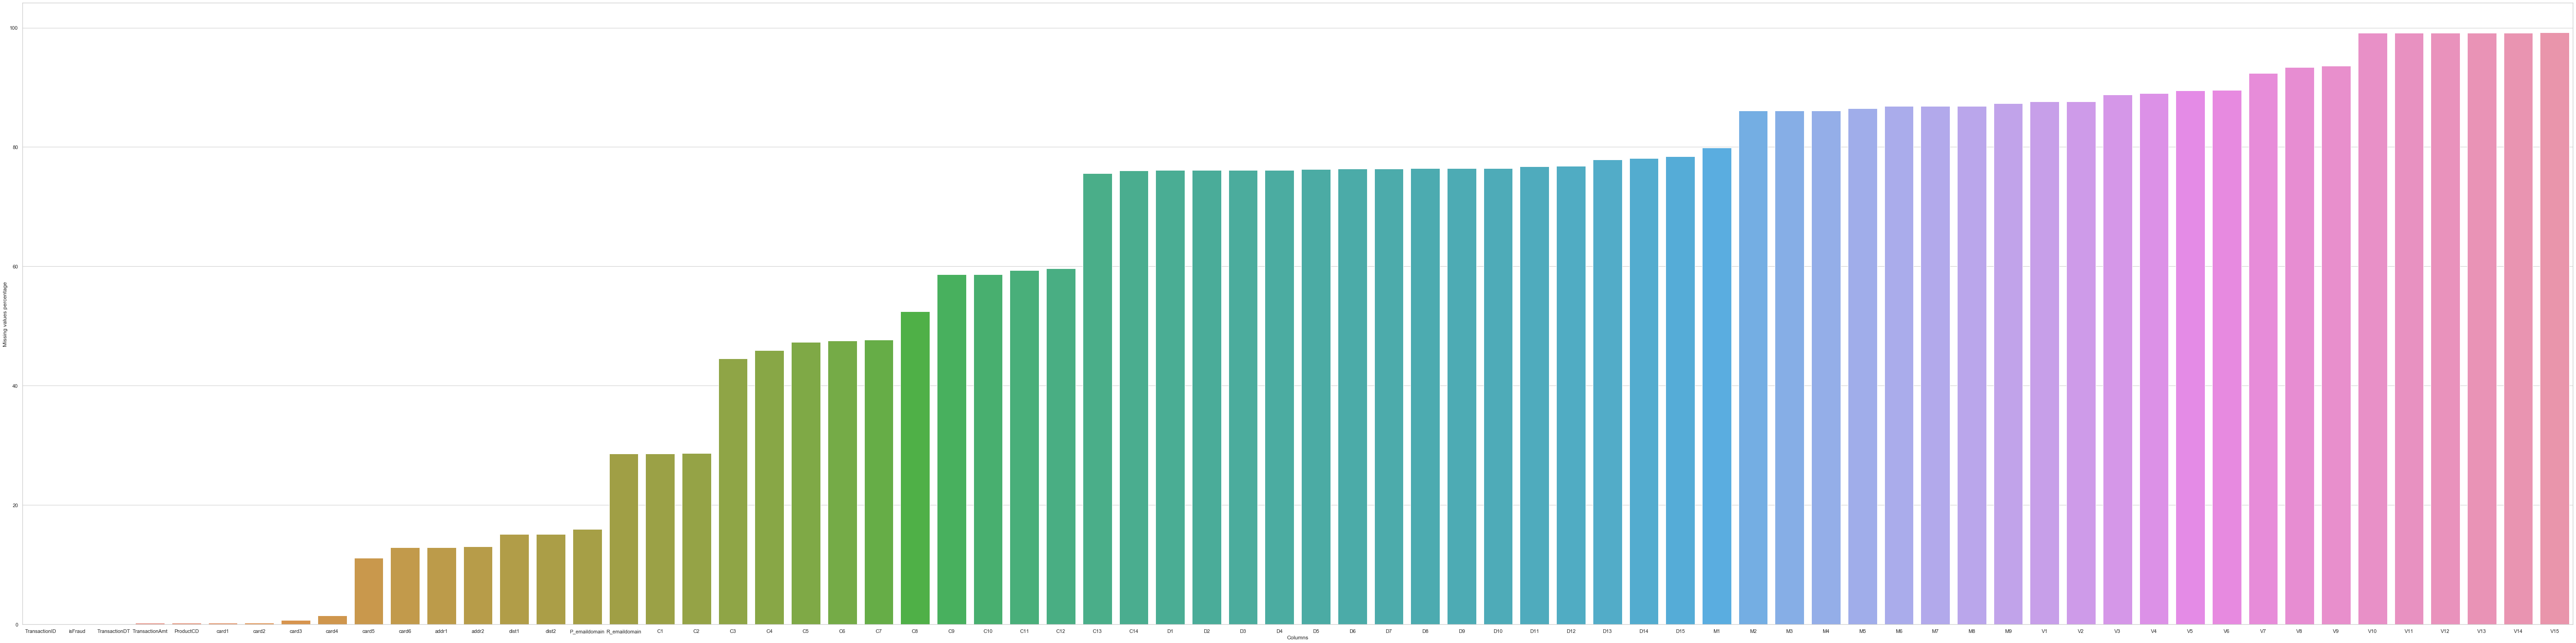

In [59]:
plt.figure(figsize=(100,25))
p = sns.barplot(x = 'Columns', y = 'Missing values percentage', data = missing_data)
p.set_xticklabels(list(train.columns))
p

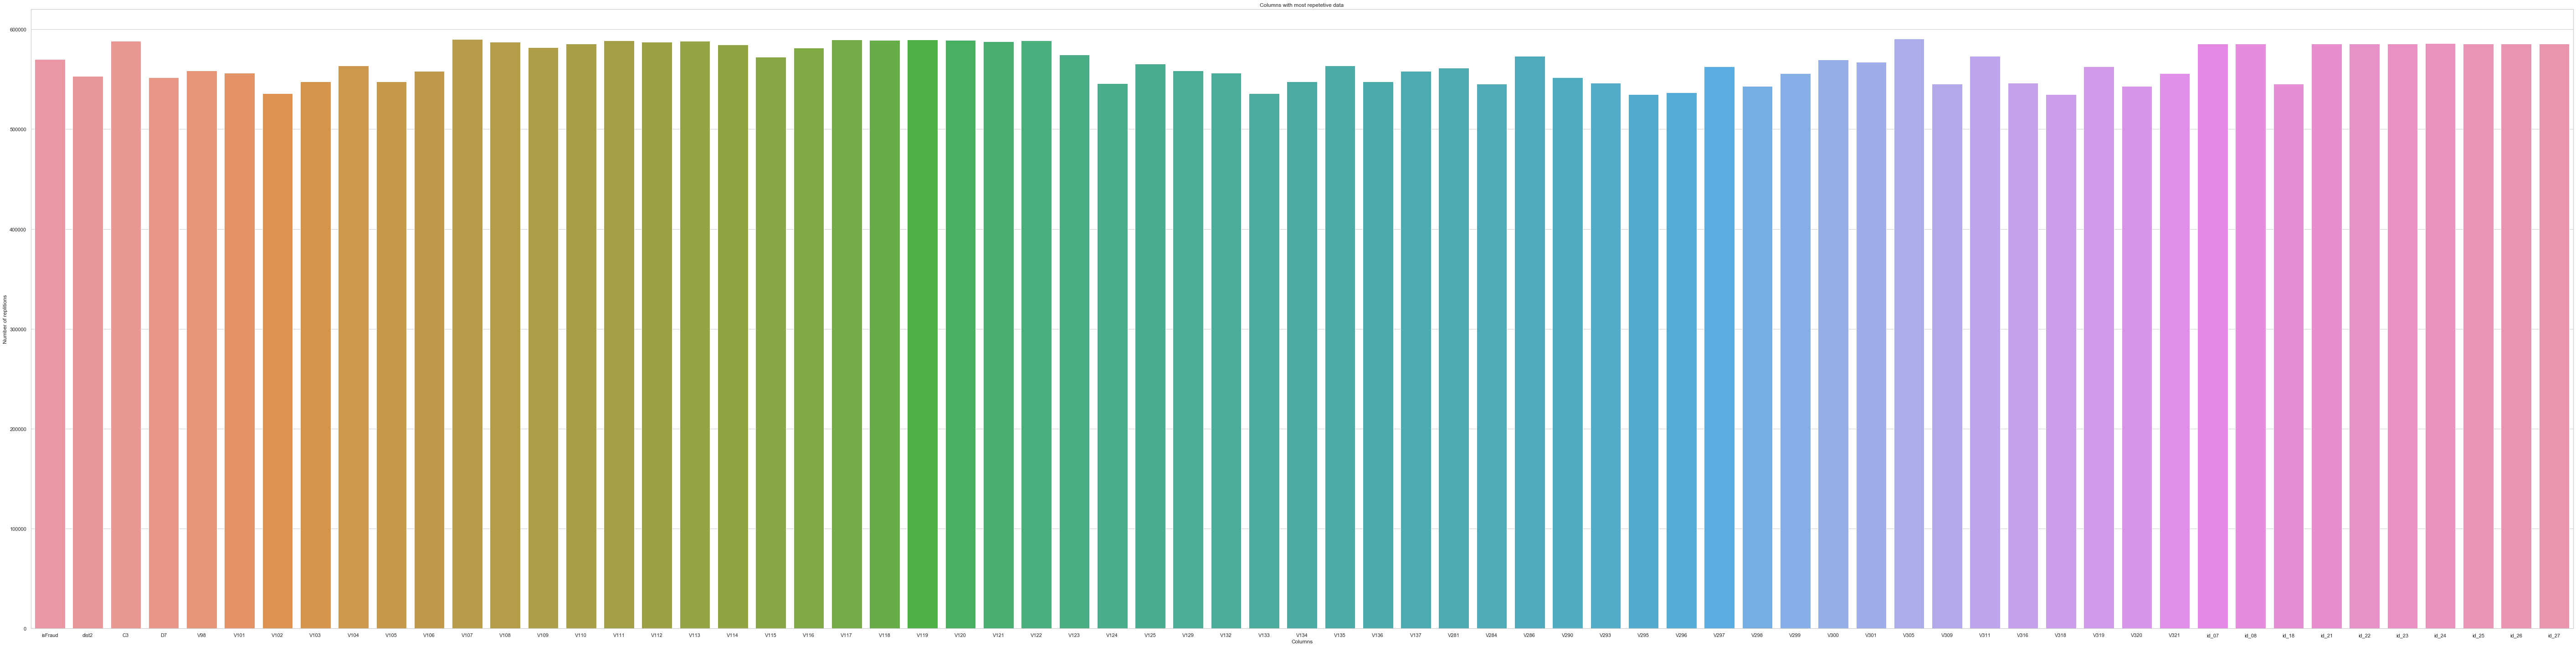

In [60]:
plt.figure(figsize=(100,25))
p2 = sns.barplot(x = rep_vals, y = cols)
plt.title("Columns with most repetetive data")
p2.set(xlabel='Columns', ylabel='Number of replitions')
p2

In [ ]:
train.head()

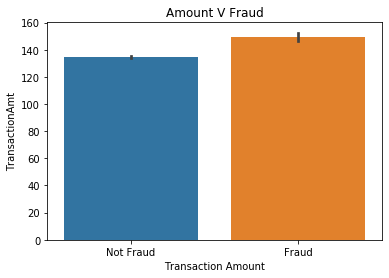

In [52]:
amnt = sns.barplot(x = train['isFraud'], y = train['TransactionAmt'], data = train)
plt.title("Amount V Fraud")
amnt.set_xticklabels(['Not Fraud','Fraud'])
amnt.set(xlabel='Transaction Amount')
amnt

In [ ]:
sns.countplot(train['ProductCD'], hue='isFraud', data=train)

In [ ]:
for i in range(1,7):
    mv1 = find_Major_values(train['card'+str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['card'+str(i)])
    plothis1 = find_plot(md1, train, train['card'+str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['card'+str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of card number "+str(i))
        p4.set(xlabel='card data of card number '+str(i), ylabel='Count')
        p4

In [ ]:
for i in range(1, 15):
    mv1 = find_Major_values(train['C' + str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['C' + str(i)])
    plothis1 = find_plot(md1, train, train['C' + str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['C' + str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of C" + str(i))
        p4.set(xlabel='C data of C' + str(i), ylabel='Count')
        p4

In [ ]:
for i in range(1, 16):
    mv1 = find_Major_values(train['D' + str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['D' + str(i)])
    plothis1 = find_plot(md1, train, train['D' + str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['D' + str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of D" + str(i))
        p4.set(xlabel='D data of D' + str(i), ylabel='Count')
        p4

In [ ]:
for i in range(1, 10):
    mv1 = find_Major_values(train['M' + str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['M' + str(i)])
    plothis1 = find_plot(md1, train, train['M' + str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['M' + str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of M" + str(i))
        p4.set(xlabel='M data of M' + str(i), ylabel='Count')
        p4

In [ ]:
for i in range(1,10):
    mv1 = find_Major_values(train['id_0'+str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['id_0'+str(i)])
    plothis1 = find_plot(md1, train, train['id_0'+str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['id_0'+str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of an id_"+str(i))
        p4.set(xlabel='id data of id_'+str(i), ylabel='Count')
        p4

In [ ]:
for i in range(10,39):
    mv1 = find_Major_values(train['id_'+str(i)], 0.05)
    md1 = find_Major_Devices(mv1, train['id_'+str(i)])
    plothis1 = find_plot(md1, train, train['id_'+str(i)])
    plt.figure(figsize=(12,5))
    if type(plothis1) != int:
        p4 = sns.countplot(x = plothis1['id_'+str(i)], hue = plothis1['isFraud'], data= plothis1)
        plt.title("Data analysis of id_"+str(i))
        p4.set(xlabel='id data of id_'+str(i), ylabel='Count')
        p4